# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844



In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
# change to your folder directory
# %cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
%cd "/content/drive/MyDrive/EE247_FinalProject/project"

Mounted at /content/drive
/content/drive/MyDrive/EE247_FinalProject/project


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

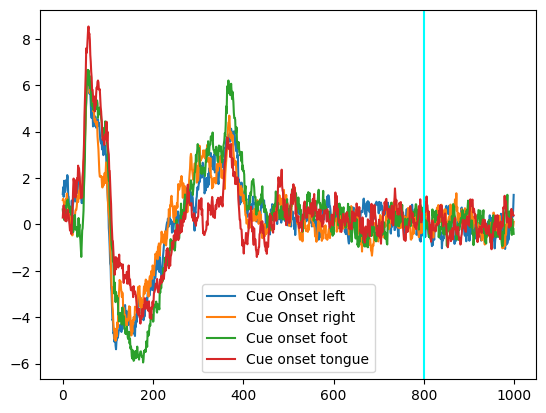

In [ ]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [ ]:
def train_data_prep(X,y,sub_sample,average,noise,time_sel=900):
    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,900)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,900) -> (sample,22,900/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    return total_X,total_y



def val_test_data_prep(X,time_sel=900):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,900)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,900) -> (sample,22,900/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [ ]:
def data_loader(X_train_valid, y_train_valid, model_choice="EEG", time_sel=900, z_norm=False):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True,time_sel)

    if model_choice == "EEG":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])


    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data, time_sel)


    if model_choice == "EEG":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])


    print("My training data: ", train_data_aug.shape)
    print("My training label: ", train_label_aug.shape)
    print()
    print("My val data: ", val_data_aug.shape)
    print("My val label: ", val_label.shape)
    print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data
    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [ ]:
np.random.seed(247)
x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG = data_loader(X_train_valid, y_train_valid, model_choice="EEG")

My training data:  (6768, 1, 22, 450)
My training label:  (6768,)

My val data:  (423, 1, 22, 450)
My val label:  (423,)



In [ ]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [ ]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30, anneal_=False, scheduler_coeff = 10, T_mult=1):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    if anneal_ == True:
        print("Annealing")
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations*scheduler_coeff)

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    np.random.seed(247)
    torch.manual_seed(147)
    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            if anneal_ == True:
                scheduler.step()
                # print(scheduler.get_last_lr())

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            print("Check: ", x_valid.shape)
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))


        if (anneal_ == True) and ((epoch+1) % scheduler_coeff == 0):
            print('Reset scheduler after finishing epoch: ', epoch+1)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_mult=T_mult, T_0=num_iterations*scheduler_coeff)

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [ ]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, model_choice="EEG", X_test=X_test, y_test=y_test,time_sel=900):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test,time_sel)


    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "EEG" or model_choice == "Speech":
            x_test = x_test.unsqueeze(1)


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", model_choice, "is: ", test_acc)

    return y_test, test_predict

# **MODEL DEFINITION**





> Here, we define the model used in this experiment. Our model is:
1.  EEG Net + Cosine Annealing

In [ ]:
## Defining EEG_NET architecture

class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()     #EEGNet is a subclass for nn.Module base class

        layers=[]
        num_classes=4
        num_channel = 22
        fs = 250
        dropoutRate = 0.25
        filter_len = fs//2
        F1 = 8
        D = 2
        F2 = 16

        layers = []
        # Block 1
        # Input shape: N*1*C*T
        layers.append(nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=[1, filter_len], padding='same', bias=False))
        layers.append(nn.BatchNorm2d(num_features=F1))
        layers.append(ConstrainedConv2d(in_channels=F1, out_channels=D*F1, groups=F1, kernel_size=[num_channel, 1], padding='valid', bias=False))
        layers.append(nn.BatchNorm2d(num_features=D*F1))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,4]))
        layers.append(nn.Dropout(dropoutRate))

        #Block2
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=D*F1, groups=D*F1, kernel_size=[1, filter_len//2], padding="same"))
        layers.append(nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=1))
        layers.append(nn.BatchNorm2d(num_features=F2))
        layers.append(nn.ELU())
        layers.append(nn.AvgPool2d([1,8]))
        layers.append(nn.Dropout(dropoutRate))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=224, out_features=100))
        layers.append(nn.Linear(in_features=100, out_features=10))
        layers.append(nn.Linear(in_features=10, out_features=num_classes))

        self.model = nn.ModuleList(layers)


    def forward(self, x):

        for layer in self.model:
            x = layer(x)

        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eeg_net = EEGNet().to(device)
summary(eeg_net, input_size=x_train_EEG[0:64].shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [64, 4]                   --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 8, 22, 450]          1,000
│    └─BatchNorm2d: 2-2                  [64, 8, 22, 450]          16
│    └─ConstrainedConv2d: 2-3            [64, 16, 1, 450]          352
│    └─BatchNorm2d: 2-4                  [64, 16, 1, 450]          32
│    └─ELU: 2-5                          [64, 16, 1, 450]          --
│    └─AvgPool2d: 2-6                    [64, 16, 1, 112]          --
│    └─Dropout: 2-7                      [64, 16, 1, 112]          --
│    └─Conv2d: 2-8                       [64, 16, 1, 112]          1,008
│    └─Conv2d: 2-9                       [64, 16, 1, 112]          272
│    └─BatchNorm2d: 2-10                 [64, 16, 1, 112]          32
│    └─ELU: 2-11                         [64, 16, 1, 112]          --
│    └─

# **Training Our Models**

In [ ]:
###################################################################################
## Training and Test The EEGNet with Annealing ####################################
###################################################################################

eeg_net = EEGNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(eeg_net.parameters(), lr=1e-2, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_eeg = {
    "x_train": x_train_EEG,
    "y_train": y_train_EEG,
    "x_valid": x_valid_EEG,
    "y_valid": y_valid_EEG
}
training_acc_EEG, validation_acc_EEG = train_model(data_eeg, optimizer, criterion, eeg_net, batch_size, num_epoch, anneal_=True,  T_mult=1)
start_time = time.time()
test_predict, test_predict = test_model(eeg_net, model_choice="EEG", X_test=X_test, y_test=y_test, time_sel=900)
print("Time To Run: ", time.time() - start_time, "seconds")

Annealing
Current Model:  EEGNet(
  (model): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConstrainedConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 62), stride=(1, 1), padding=same, groups=16)
    (8): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): AvgPool2d(kernel_size=[1, 8], stride=[1, 8], padding=0)
    (12): Dropout(p=0.25, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=224, out

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.341
[1, 52] loss: 1.274
[1, 78] loss: 1.218


  2%|▏         | 1/50 [00:00<00:47,  1.02it/s]

[1, 104] loss: 1.167
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.4893617033958435
Epoch:  2
[2, 26] loss: 1.140
[2, 52] loss: 1.115
[2, 78] loss: 1.136


  4%|▍         | 2/50 [00:01<00:44,  1.07it/s]

[2, 104] loss: 1.117
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.5697399377822876
Epoch:  3
[3, 26] loss: 1.112
[3, 52] loss: 1.046
[3, 78] loss: 1.063


  6%|▌         | 3/50 [00:02<00:43,  1.09it/s]

[3, 104] loss: 1.060
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.5744680762290955
Epoch:  4
[4, 26] loss: 1.017
[4, 52] loss: 0.990
[4, 78] loss: 0.995


  8%|▊         | 4/50 [00:03<00:42,  1.09it/s]

[4, 104] loss: 0.980
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6193853616714478
Epoch:  5
[5, 26] loss: 0.962
[5, 52] loss: 0.927
[5, 78] loss: 0.921


 10%|█         | 5/50 [00:04<00:41,  1.10it/s]

[5, 104] loss: 0.969
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6241135001182556
Epoch:  6
[6, 26] loss: 0.900
[6, 52] loss: 0.884
[6, 78] loss: 0.884


 12%|█▏        | 6/50 [00:05<00:40,  1.10it/s]

[6, 104] loss: 0.899
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6501182317733765
Epoch:  7
[7, 26] loss: 0.856
[7, 52] loss: 0.878
[7, 78] loss: 0.836


 14%|█▍        | 7/50 [00:06<00:39,  1.10it/s]

[7, 104] loss: 0.847
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6808510422706604
Epoch:  8
[8, 26] loss: 0.831
[8, 52] loss: 0.819
[8, 78] loss: 0.815


 16%|█▌        | 8/50 [00:07<00:38,  1.10it/s]

[8, 104] loss: 0.847
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6784870028495789
Epoch:  9
[9, 26] loss: 0.809
[9, 52] loss: 0.827
[9, 78] loss: 0.803


 18%|█▊        | 9/50 [00:08<00:37,  1.10it/s]

[9, 104] loss: 0.808
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6879432797431946
Epoch:  10
[10, 26] loss: 0.815
[10, 52] loss: 0.794
[10, 78] loss: 0.806


 20%|██        | 10/50 [00:09<00:36,  1.10it/s]

[10, 104] loss: 0.796
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6855791807174683
Reset scheduler after finishing epoch:  10
Epoch:  11
[11, 26] loss: 0.913
[11, 52] loss: 0.921
[11, 78] loss: 0.947


 22%|██▏       | 11/50 [00:10<00:35,  1.09it/s]

[11, 104] loss: 0.927
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6453900933265686
Epoch:  12
[12, 26] loss: 0.914
[12, 52] loss: 0.896
[12, 78] loss: 0.904


 24%|██▍       | 12/50 [00:10<00:34,  1.09it/s]

[12, 104] loss: 0.897
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6548463106155396
Epoch:  13
[13, 26] loss: 0.919
[13, 52] loss: 0.864
[13, 78] loss: 0.881


 26%|██▌       | 13/50 [00:11<00:33,  1.09it/s]

[13, 104] loss: 0.869
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.609929084777832
Epoch:  14
[14, 26] loss: 0.875
[14, 52] loss: 0.887
[14, 78] loss: 0.821


 28%|██▊       | 14/50 [00:12<00:33,  1.09it/s]

[14, 104] loss: 0.845
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6855791807174683
Epoch:  15
[15, 26] loss: 0.813
[15, 52] loss: 0.855
[15, 78] loss: 0.845


 30%|███       | 15/50 [00:13<00:32,  1.09it/s]

[15, 104] loss: 0.822
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6572104096412659
Epoch:  16
[16, 26] loss: 0.802
[16, 52] loss: 0.826
[16, 78] loss: 0.819


 32%|███▏      | 16/50 [00:14<00:31,  1.09it/s]

[16, 104] loss: 0.802
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6926714181900024
Epoch:  17
[17, 26] loss: 0.764
[17, 52] loss: 0.765
[17, 78] loss: 0.778


 34%|███▍      | 17/50 [00:15<00:30,  1.09it/s]

[17, 104] loss: 0.782
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6926714181900024
Epoch:  18
[18, 26] loss: 0.759
[18, 52] loss: 0.763
[18, 78] loss: 0.780


 36%|███▌      | 18/50 [00:16<00:29,  1.09it/s]

[18, 104] loss: 0.772
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7092198729515076
Epoch:  19
[19, 26] loss: 0.748
[19, 52] loss: 0.754
[19, 78] loss: 0.760


 38%|███▊      | 19/50 [00:17<00:28,  1.08it/s]

[19, 104] loss: 0.750
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7115839123725891
Epoch:  20
[20, 26] loss: 0.725
[20, 52] loss: 0.743
[20, 78] loss: 0.760


 40%|████      | 20/50 [00:18<00:27,  1.08it/s]

[20, 104] loss: 0.740
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7115839123725891
Reset scheduler after finishing epoch:  20
Epoch:  21
[21, 26] loss: 0.837
[21, 52] loss: 0.853
[21, 78] loss: 0.909


 42%|████▏     | 21/50 [00:19<00:26,  1.08it/s]

[21, 104] loss: 0.861
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6643025875091553
Epoch:  22
[22, 26] loss: 0.880
[22, 52] loss: 0.864
[22, 78] loss: 0.867


 44%|████▍     | 22/50 [00:20<00:25,  1.08it/s]

[22, 104] loss: 0.838
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6926714181900024
Epoch:  23
[23, 26] loss: 0.832
[23, 52] loss: 0.849
[23, 78] loss: 0.815


 46%|████▌     | 23/50 [00:21<00:24,  1.08it/s]

[23, 104] loss: 0.833
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6879432797431946
Epoch:  24
[24, 26] loss: 0.804
[24, 52] loss: 0.801
[24, 78] loss: 0.821


 48%|████▊     | 24/50 [00:22<00:24,  1.08it/s]

[24, 104] loss: 0.829
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6973995566368103
Epoch:  25
[25, 26] loss: 0.774
[25, 52] loss: 0.798
[25, 78] loss: 0.796


 50%|█████     | 25/50 [00:23<00:23,  1.08it/s]

[25, 104] loss: 0.788
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7068557739257812
Epoch:  26
[26, 26] loss: 0.797
[26, 52] loss: 0.773
[26, 78] loss: 0.762


 52%|█████▏    | 26/50 [00:23<00:22,  1.07it/s]

[26, 104] loss: 0.758
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7470449209213257
Epoch:  27
[27, 26] loss: 0.765
[27, 52] loss: 0.753
[27, 78] loss: 0.744


 54%|█████▍    | 27/50 [00:24<00:21,  1.07it/s]

[27, 104] loss: 0.749
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7257683277130127
Epoch:  28
[28, 26] loss: 0.743
[28, 52] loss: 0.734
[28, 78] loss: 0.739


 56%|█████▌    | 28/50 [00:25<00:20,  1.07it/s]

[28, 104] loss: 0.717
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7257683277130127
Epoch:  29
[29, 26] loss: 0.706
[29, 52] loss: 0.714
[29, 78] loss: 0.727


 58%|█████▊    | 29/50 [00:26<00:19,  1.07it/s]

[29, 104] loss: 0.717
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7352246046066284
Epoch:  30
[30, 26] loss: 0.700
[30, 52] loss: 0.727
[30, 78] loss: 0.701


 60%|██████    | 30/50 [00:27<00:18,  1.07it/s]

[30, 104] loss: 0.715
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7423167824745178
Reset scheduler after finishing epoch:  30
Epoch:  31
[31, 26] loss: 0.811
[31, 52] loss: 0.842
[31, 78] loss: 0.823


 62%|██████▏   | 31/50 [00:28<00:17,  1.07it/s]

[31, 104] loss: 0.828
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7281323671340942
Epoch:  32
[32, 26] loss: 0.823
[32, 52] loss: 0.815
[32, 78] loss: 0.859


 64%|██████▍   | 32/50 [00:29<00:16,  1.07it/s]

[32, 104] loss: 0.850
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7210401892662048
Epoch:  33
[33, 26] loss: 0.817
[33, 52] loss: 0.844
[33, 78] loss: 0.763


 66%|██████▌   | 33/50 [00:30<00:15,  1.07it/s]

[33, 104] loss: 0.802
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6453900933265686
Epoch:  34
[34, 26] loss: 0.810
[34, 52] loss: 0.771
[34, 78] loss: 0.781


 68%|██████▊   | 34/50 [00:31<00:15,  1.07it/s]

[34, 104] loss: 0.810
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7115839123725891
Epoch:  35
[35, 26] loss: 0.760
[35, 52] loss: 0.759
[35, 78] loss: 0.756


 70%|███████   | 35/50 [00:32<00:14,  1.06it/s]

[35, 104] loss: 0.758
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7044917345046997
Epoch:  36
[36, 26] loss: 0.765
[36, 52] loss: 0.751
[36, 78] loss: 0.748


 72%|███████▏  | 36/50 [00:33<00:13,  1.06it/s]

[36, 104] loss: 0.746
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7092198729515076
Epoch:  37
[37, 26] loss: 0.725
[37, 52] loss: 0.740
[37, 78] loss: 0.723


 74%|███████▍  | 37/50 [00:34<00:12,  1.06it/s]

[37, 104] loss: 0.737
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7565011978149414
Epoch:  38
[38, 26] loss: 0.716
[38, 52] loss: 0.722
[38, 78] loss: 0.701


 76%|███████▌  | 38/50 [00:35<00:11,  1.06it/s]

[38, 104] loss: 0.694
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7446808815002441
Epoch:  39
[39, 26] loss: 0.695
[39, 52] loss: 0.682
[39, 78] loss: 0.721


 78%|███████▊  | 39/50 [00:36<00:10,  1.06it/s]

[39, 104] loss: 0.704
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7446808815002441
Epoch:  40
[40, 26] loss: 0.685
[40, 52] loss: 0.702
[40, 78] loss: 0.707


 80%|████████  | 40/50 [00:37<00:09,  1.06it/s]

[40, 104] loss: 0.699
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7470449209213257
Reset scheduler after finishing epoch:  40
Epoch:  41
[41, 26] loss: 0.749
[41, 52] loss: 0.808
[41, 78] loss: 0.816


 82%|████████▏ | 41/50 [00:38<00:08,  1.06it/s]

[41, 104] loss: 0.804
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.6832151412963867
Epoch:  42
[42, 26] loss: 0.782
[42, 52] loss: 0.799
[42, 78] loss: 0.811


 84%|████████▍ | 42/50 [00:39<00:07,  1.06it/s]

[42, 104] loss: 0.811
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7328605055809021
Epoch:  43
[43, 26] loss: 0.783
[43, 52] loss: 0.803
[43, 78] loss: 0.774


 86%|████████▌ | 43/50 [00:39<00:06,  1.06it/s]

[43, 104] loss: 0.783
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.716312050819397
Epoch:  44
[44, 26] loss: 0.755
[44, 52] loss: 0.791
[44, 78] loss: 0.765


 88%|████████▊ | 44/50 [00:40<00:05,  1.06it/s]

[44, 104] loss: 0.759
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7352246046066284
Epoch:  45
[45, 26] loss: 0.761
[45, 52] loss: 0.761
[45, 78] loss: 0.746


 90%|█████████ | 45/50 [00:41<00:04,  1.06it/s]

[45, 104] loss: 0.766
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7115839123725891
Epoch:  46
[46, 26] loss: 0.720
[46, 52] loss: 0.738
[46, 78] loss: 0.730


 92%|█████████▏| 46/50 [00:42<00:03,  1.06it/s]

[46, 104] loss: 0.721
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7186761498451233
Epoch:  47
[47, 26] loss: 0.709
[47, 52] loss: 0.715
[47, 78] loss: 0.720


 94%|█████████▍| 47/50 [00:43<00:02,  1.07it/s]

[47, 104] loss: 0.700
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7281323671340942
Epoch:  48
[48, 26] loss: 0.698
[48, 52] loss: 0.694
[48, 78] loss: 0.688


 96%|█████████▌| 48/50 [00:44<00:01,  1.07it/s]

[48, 104] loss: 0.700
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7304964661598206
Epoch:  49
[49, 26] loss: 0.692
[49, 52] loss: 0.678
[49, 78] loss: 0.670


 98%|█████████▊| 49/50 [00:45<00:00,  1.07it/s]

[49, 104] loss: 0.701
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7541370987892151
Epoch:  50
[50, 26] loss: 0.694
[50, 52] loss: 0.685
[50, 78] loss: 0.688


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

[50, 104] loss: 0.655
Check:  torch.Size([423, 1, 22, 450])
Validation Accuracy: 0.7470449209213257
Reset scheduler after finishing epoch:  50
Finish Training


Test accuracy for  EEG is:  0.7539503386004515
Time To Run:  0.22390484809875488 seconds


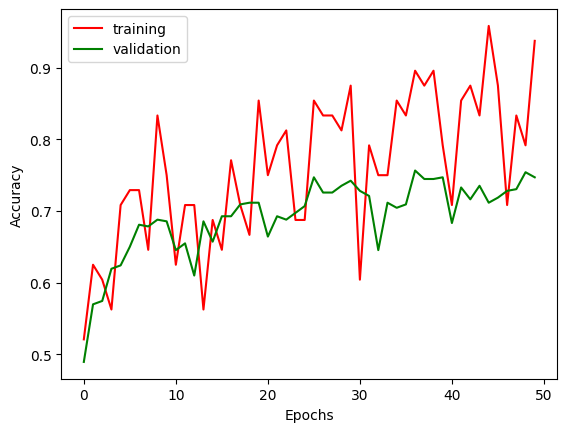

In [ ]:
make_figure(training_acc_EEG, validation_acc_EEG, name = "EEG")

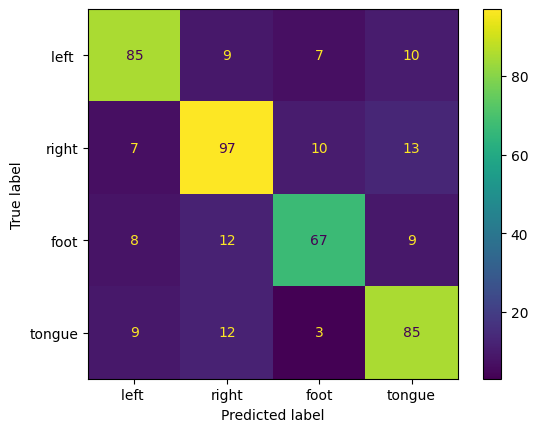

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, test_predict.to("cpu"))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ['left ','right','foot','tongue'])
cm_display.plot()
plt.show()
